In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import awkward1 as ak

from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection
from klepto.archives import dir_archive

import numpy as np

from processor.forward_jet import *


In [3]:
# load the basic filesets and choose what samples we actually want to load

from Tools.samples import fileset_2018
from processor.std_acumulators import variations, desired_output

fileset_2018.keys()

dict_keys(['tW_scattering', 'topW_v2', 'TTXnoW', 'TTW', 'TTH', 'TTZ', 'TTTT', 'ttbar', 'ttbar1l', 'ttbar2l', 'ttbar1l_MG', 'wjets', 'diboson', 'triboson', 'WW', 'WZ', 'DY', 'MuonEG'])

In [4]:
%%time
overwrite = False
year = 2018

# load the config and the cache
cfg = loadConfig()

cacheName = 'forward'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
histograms = sorted(list(desired_output.keys()))

'''
fileset = {
    'tW_scattering': glob.glob("/hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/*.root"),
    'topW_v2': glob.glob("/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/*.root"),
    
}
'''


fileset = {
    #'tW_scattering': fileset_2018['tW_scattering'],
    'topW_v2': fileset_2018['topW_v2'],
    'ttbar': fileset_2018['ttbar2l'], # dilepton ttbar should be enough for this study.
    'MuonEG': fileset_2018['MuonEG'],
    'WW': fileset_2018['WW'],
    'WZ': fileset_2018['WZ'],
    'DY': fileset_2018['DY'],
}


exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        forwardJetAnalyzer(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

CPU times: user 72.7 ms, sys: 3.23 s, total: 3.3 s
Wall time: 17.3 s


~22s for baseline code


In [5]:
# Cutflow
from Tools.helpers import getCutFlowTable

#processes = ['tW_scattering', 'topW_v2']
processes = ['DY', 'ttbar', 'WW', 'WZ', 'MuonEG']

# let's use the S/B functionality to get data/MC by defining data (MuonEG) as signal
lines = ['entry']
lines += ['lepveto', 'dilep', 'trigger', 'filter', 'p_T(lep0)>25', 'p_T(lep1)>20',  'OS', 'N_btag=2', 'N_jet>2', 'N_fwd>0', 'MET>30']
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4,
                    # signal='MuonEG'
                    )
df

,DY,ttbar,WW,WZ,MuonEG
entry,85530000.0 +/- 20000.0,4243000.0 +/- 1000.0,411600.0 +/- 200.0,234600.0 +/- 100.0,62830000.0 +/- 10000.0
lepveto,76720000.0 +/- 20000.0,2043000.0 +/- 1000.0,151200.0 +/- 100.0,109000.0 +/- 100.0,6093000.0 +/- 2000.0
dilep,63330.0 +/- 460.0,339200.0 +/- 200.0,28460.0 +/- 50.0,2871.0 +/- 15.0,407100.0 +/- 600.0
trigger,55040.0 +/- 430.0,316600.0 +/- 200.0,26440.0 +/- 50.0,2613.0 +/- 14.0,399500.0 +/- 600.0
filter,55040.0 +/- 430.0,316500.0 +/- 200.0,26430.0 +/- 50.0,2610.0 +/- 14.0,399300.0 +/- 600.0
p_T(lep0)>25,51970.0 +/- 410.0,315000.0 +/- 200.0,26280.0 +/- 50.0,2575.0 +/- 14.0,394300.0 +/- 600.0
p_T(lep1)>20,43710.0 +/- 380.0,287500.0 +/- 200.0,24930.0 +/- 50.0,2283.0 +/- 13.0,353000.0 +/- 600.0
OS,43440.0 +/- 380.0,287100.0 +/- 200.0,24810.0 +/- 50.0,1155.0 +/- 9.0,349200.0 +/- 600.0
N_btag=2,96.74 +/- 18.81,108300.0 +/- 100.0,28.77 +/- 1.85,3.647 +/- 0.63,99940.0 +/- 320.0
N_jet>2,57.33 +/- 14.19,76760.0 +/- 80.0,21.21 +/- 1.58,3.068 +/- 0.572,70160.0 +/- 260.0


5.693 v0.2.3 vs 5.693 in v0.2.2 -> good

PU weight looks good, too.


In [6]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False)
df

,DY,ttbar,WW,WZ,MuonEG
entry,1.0000,1.0000,1.0000,1.0000,1.0000
lepveto,0.8970,0.4815,0.3674,0.4646,0.0970
dilep,0.0008,0.1660,0.1882,0.0263,0.0668
trigger,0.8691,0.9335,0.9288,0.9101,0.9813
filter,1.0000,0.9997,0.9998,0.9991,0.9996
p_T(lep0)>25,0.9443,0.9950,0.9941,0.9863,0.9873
p_T(lep1)>20,0.8409,0.9129,0.9489,0.8868,0.8953
OS,0.9939,0.9985,0.9951,0.5059,0.9892
N_btag=2,0.0022,0.3772,0.0012,0.0032,0.2862
N_jet>2,0.5927,0.7088,0.7373,0.8411,0.7020


/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/:
  files: 478
  nEvents: 478000
  name: ProjectMetis_TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2
  path: /hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/
  split: 207
  sumWeight: 22576.62849550001
  xsec: 0.0478

filter efficiency: 0.482

/hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/:
  files: 56
  nEvents: 54200
  name: tW_scattering_nanoAOD
  path: /hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/
  split: 56
  sumWeight: 2622.728769570001
  xsec: 0.0478
  
filter efficiency: 0.46

**I need to check where these two samples depart from each other**

Most of the selections are slightly less efficient on the new sample, but they agree within 2 sigma.
In the end it is

7.834 +/- 0.674 (old) vs 7.096 +/- 0.216 (new)

in the OS ttbar selection.

The PU distribution looks a bit odd in the old sample, but otherwise things look good.
(PU mixing has been updated in the new sample to include a larger number of neutrino gun files)


In [7]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import *
import re

bkgonly = re.compile('(?!(MuonEG))')

N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 50, -5.0, 5.0)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


Data: 0 MC: 356533.26


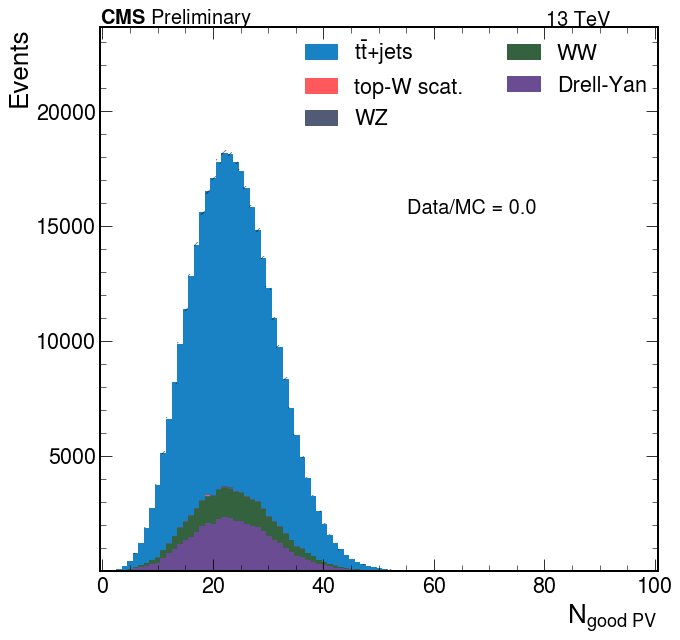

In [8]:
makePlot(output, 'PV_npvsGood', 'multiplicity',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=True, axis_label=r'$N_{good\ PV}$',
        )

Data: 349165.0 MC: 356533.26


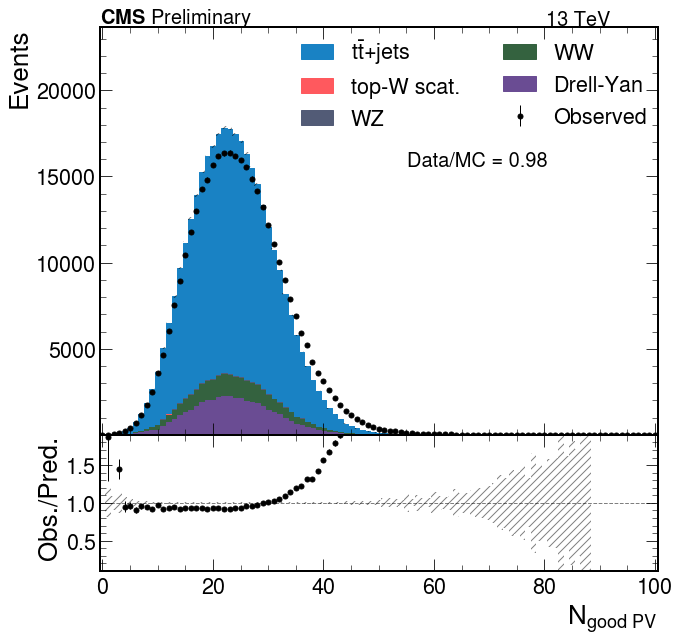

In [9]:
makePlot(output, 'PV_npvsGood', 'multiplicity',
         #data_sel=None,
         bins=None, log=False, normalize=True, axis_label=r'$N_{good\ PV}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 349165.0 MC: 356533.26


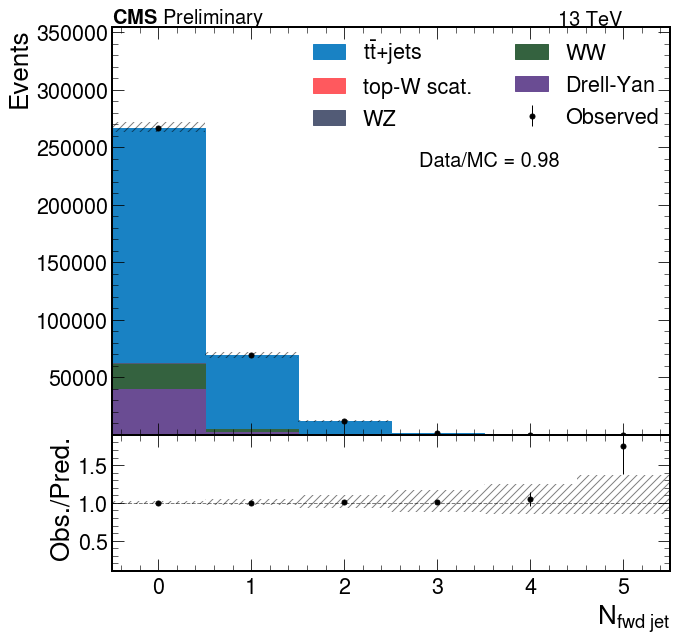

In [25]:
makePlot(output, 'N_fwd', 'multiplicity',
         #data_sel=None,
         bins=N_bins_red, log=False, normalize=True, axis_label=r'$N_{fwd\ jet}$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 349165.0 MC: 356533.26


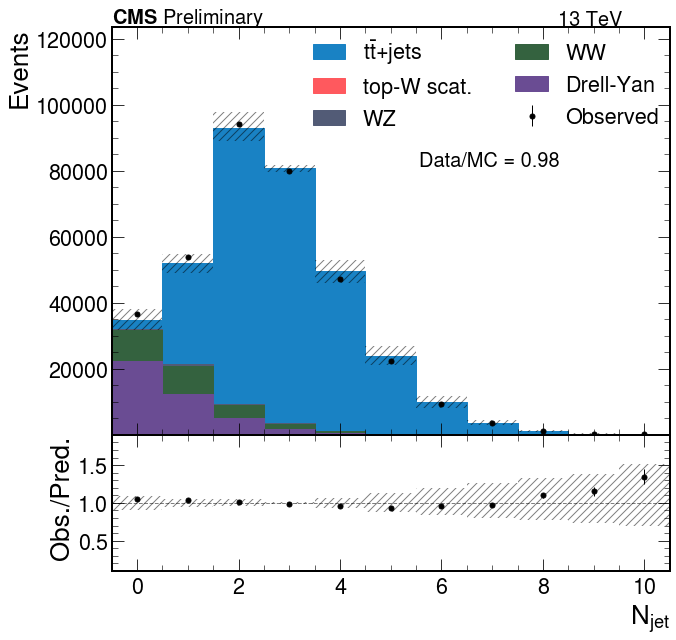

In [26]:
makePlot(output, 'N_jet', 'multiplicity',
         #data_sel=None,
         bins=N_bins, log=False, normalize=True, axis_label=r'$N_{jet}$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 349165.0 MC: 356533.26


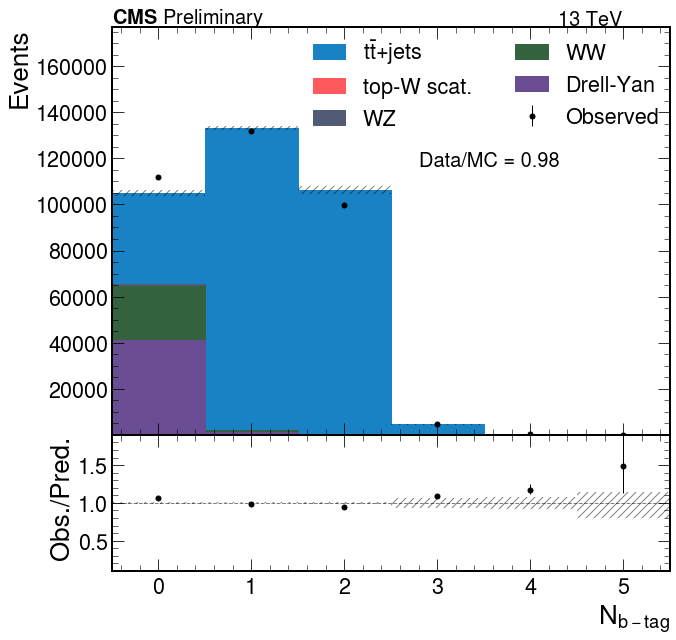

In [27]:
makePlot(output, 'N_b', 'multiplicity',
         #data_sel=None,
         bins=N_bins_red, log=False, normalize=True, axis_label=r'$N_{b-tag}$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 349165.0 MC: 356533.26


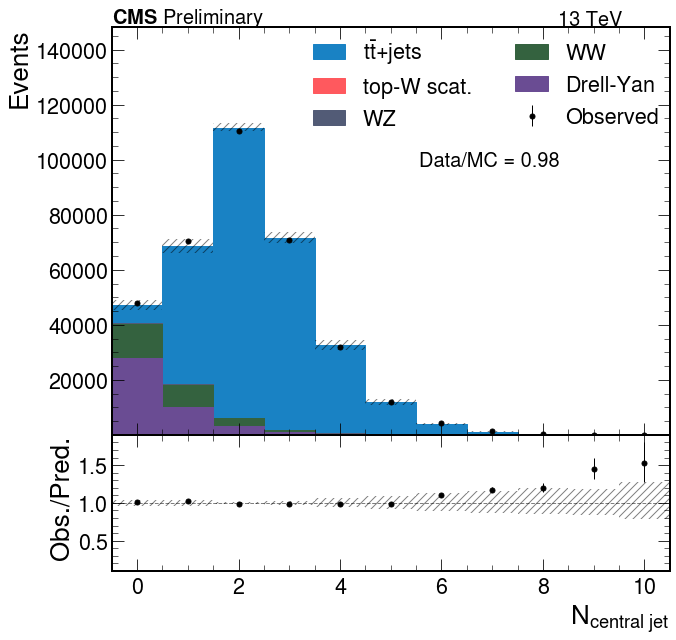

In [28]:
makePlot(output, 'N_central', 'multiplicity',
         #data_sel=None,
         bins=N_bins, log=False, normalize=True, axis_label=r'$N_{central\ jet}$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 349165.0 MC: 356533.26


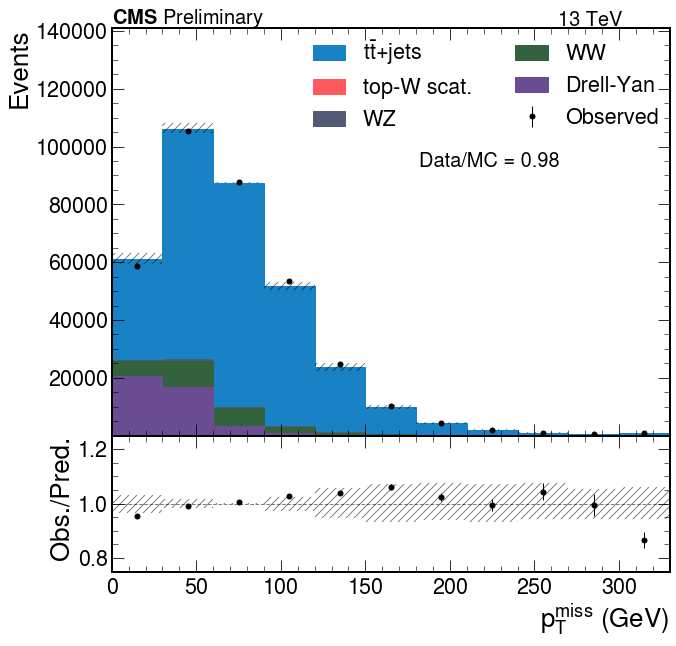

In [29]:
makePlot(output, 'MET', 'pt',
         #data_sel=None,
         bins=pt_bins_coarse, log=False, normalize=True, axis_label=r'$p_{T}^{miss}\ (GeV)$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         ratio_range = (0.75,1.25)
        )

Data: 20145.0 MC: 21790.61
Figure saved in: /home/users/dspitzba/public_html/tW_scattering/dump/fwd_pt_syst_v2


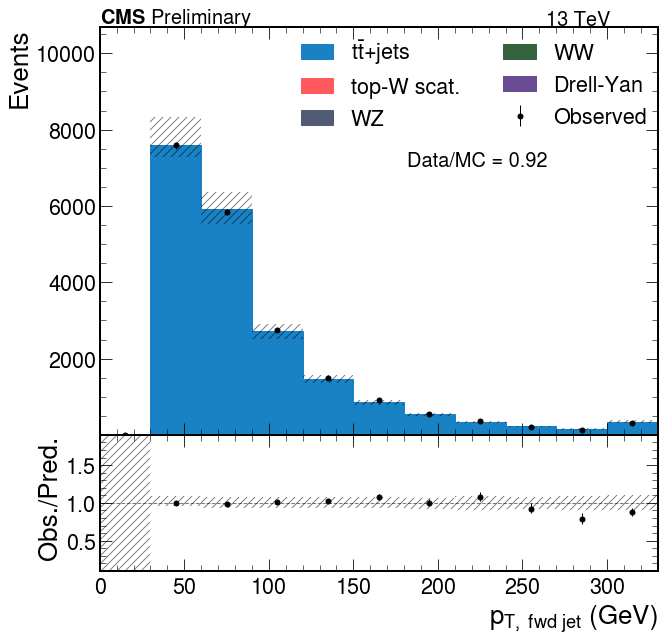

In [30]:
makePlot(output, 'fwd_jet', 'pt',
         #data_sel=None,
         bins=pt_bins_coarse, log=False, normalize=True, axis_label=r'$p_{T,\ fwd\ jet}$ (GeV)',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         save='/home/users/dspitzba/public_html/tW_scattering/dump/fwd_pt_syst_v2'
        )

Central: 21391.035863161655
Up: 23140.084144556076
Down: 20128.729675480376


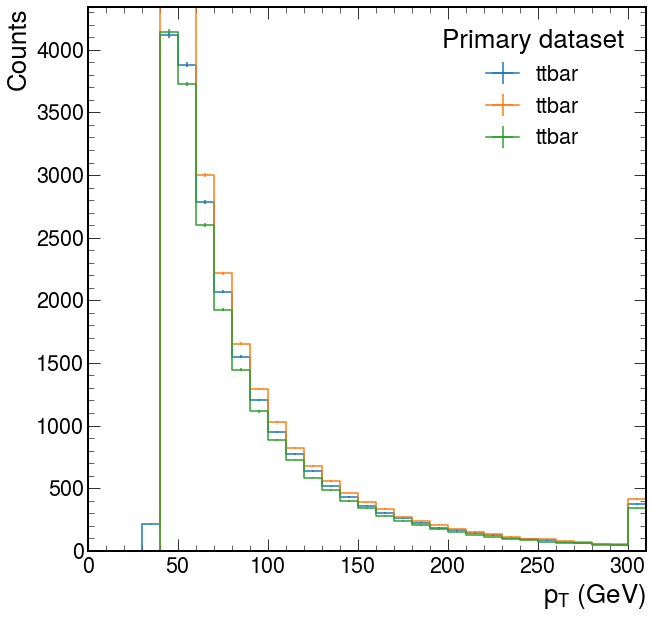

In [31]:
jet_name = 'fwd_jet'
sample_name = 'ttbar'

histogram = output[jet_name].project('pt', 'dataset').rebin('pt', pt_bins)
ax = hist.plot1d(histogram[sample_name],overlay="dataset", stack=False, overflow='over')
print ("Central:", sum(histogram[sample_name].sum('dataset', overflow='over').values()[()]))

histogram = output[jet_name+'_pt_jesTotalUp'].project('pt', 'dataset').rebin('pt', pt_bins)
ax = hist.plot1d(histogram[sample_name],overlay="dataset", stack=False, overflow='over')
print ("Up:", sum(histogram[sample_name].sum('dataset', overflow='over').values()[()]))

histogram = output[jet_name+'_pt_jesTotalDown'].project('pt', 'dataset').rebin('pt', pt_bins)
ax = hist.plot1d(histogram[sample_name],overlay="dataset", stack=False, overflow='over')
print ("Down:", sum(histogram[sample_name].sum('dataset', overflow='over').values()[()]))



Data: 20145.0 MC: 21790.61


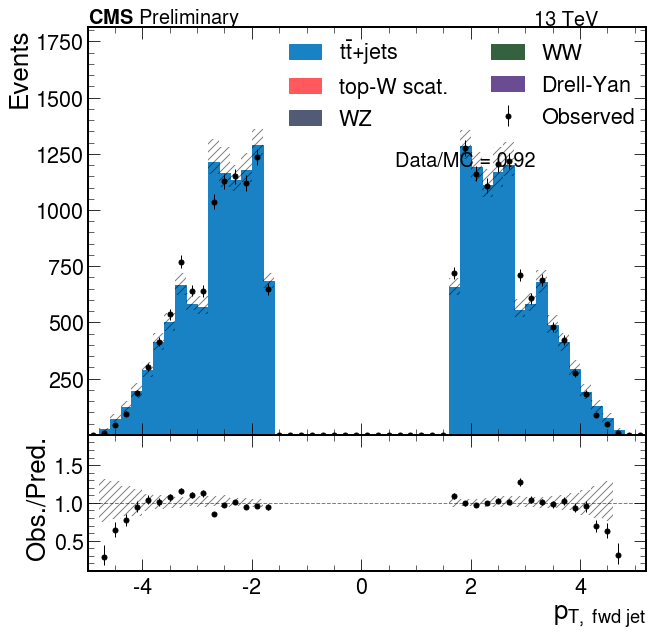

In [32]:
makePlot(output, 'fwd_jet', 'eta',
         #data_sel=None,
         bins=eta_bins, log=False, normalize=True, axis_label=r'$p_{T,\ fwd\ jet}$',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/fwd_pt_syst'
        )

Data: 20145.0 MC: 21790.61


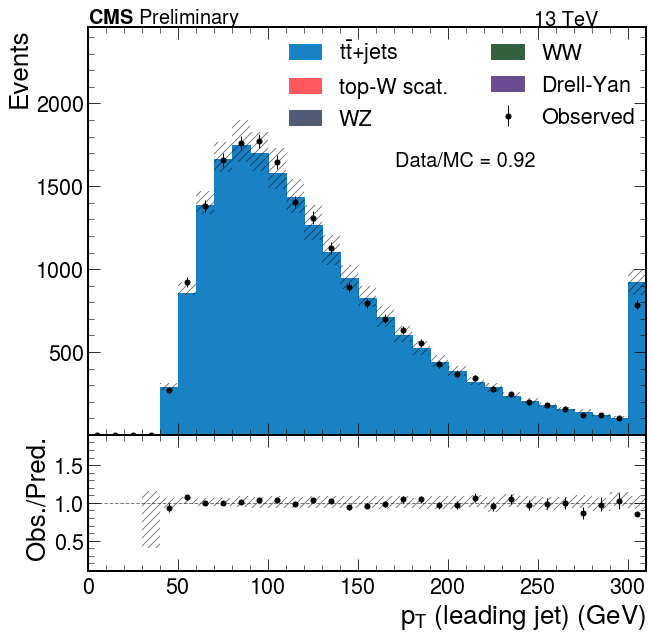

In [33]:
makePlot(output, 'j1', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (leading jet) (GeV)',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/fwd_pt_syst'
        )

Data: 20145.0 MC: 21790.61


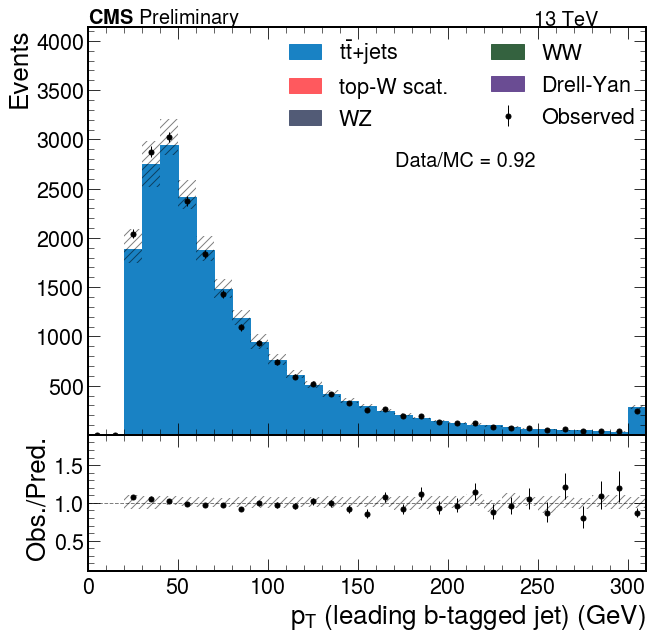

In [34]:
makePlot(output, 'b1', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (leading b-tagged jet) (GeV)',
         upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/fwd_pt_syst'
        )

Data: 20145.0 MC: 21790.61


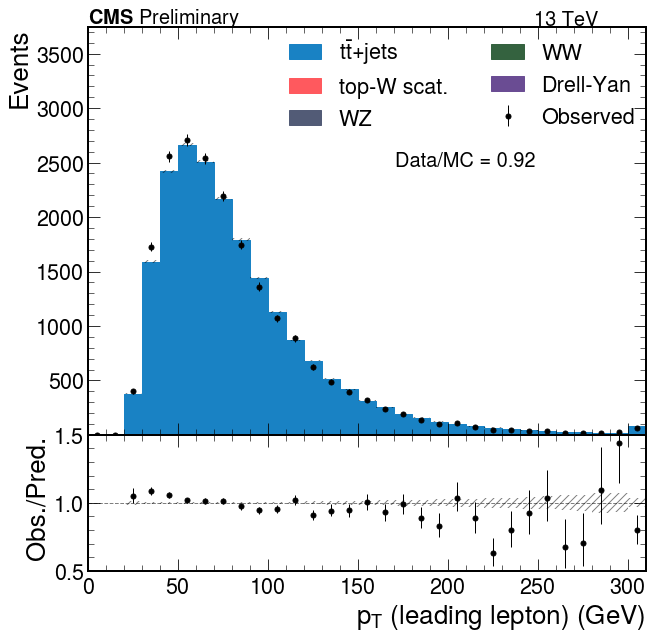

In [35]:
makePlot(output, 'lead_lep', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (leading lepton) (GeV)',
         ratio_range = (0.5,1.5)
         )

Data: 20145.0 MC: 21790.61


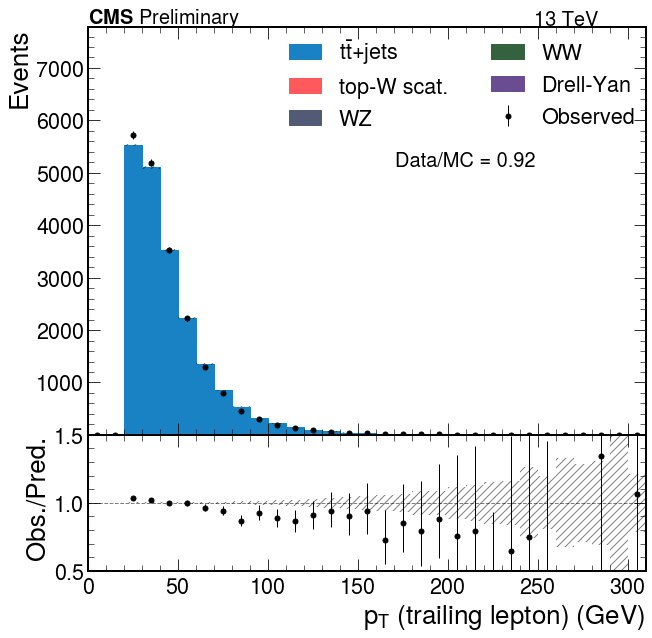

In [36]:
makePlot(output, 'trail_lep', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (trailing lepton) (GeV)',
         ratio_range = (0.5,1.5)
         )

Data: 20145.0 MC: 21790.61


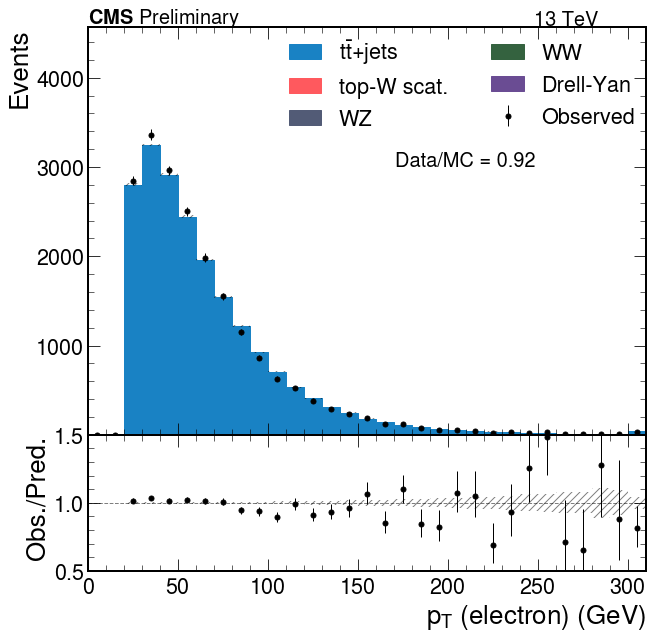

In [37]:
makePlot(output, 'electron', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (electron) (GeV)',
         ratio_range = (0.5,1.5)
         )

Data: 20145.0 MC: 21790.61


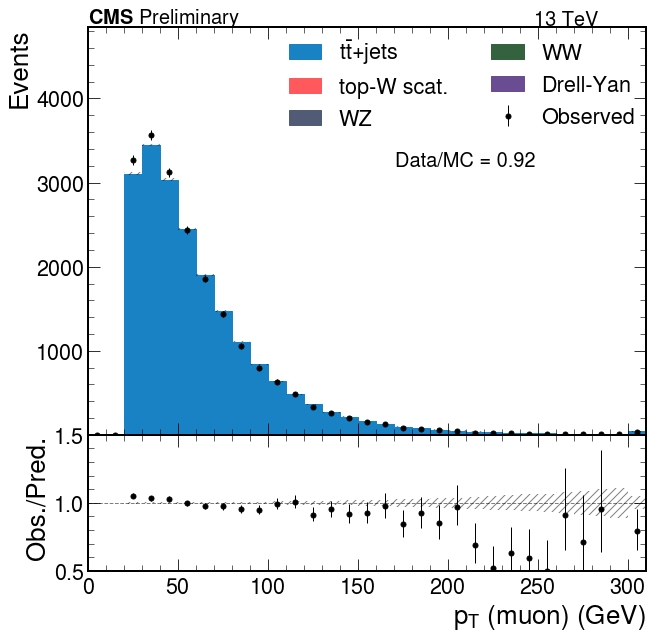

In [38]:
makePlot(output, 'muon', 'pt',
         #data_sel=None,
         bins=pt_bins, log=False, normalize=True, axis_label=r'$p_{T}$ (muon) (GeV)',
         ratio_range = (0.5,1.5)
         )

It seems like either we have a wrong normalization of ttbar, missing data events, or the lepton SFs are huge (and the PU reweighting also contributes much).

With ttH lepton IDs this is the normalization:

Data: 20146.0 MC: 28085.86

Looser SS ID:

Data: 26242.0 MC: 34977.04

There's some missing 0b simulation, potentially W+jets with a fake?

Let's implement the proper lepton SFs and then see, SFs around 0.9 will already bring data/MC to agreement.

# Some development stuff

In [4]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

# the below command will change to .from_root in coffea v0.7.0
events = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/tW_scattering_nanoAOD/nanoSkim_1.root', schemaclass=NanoAODSchema).events()

In [5]:
weight = Weights(len(events))
#weight.weight()

In [6]:
import uproot4
#fin = uproot4.open('/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/tW_scattering_nanoAOD/nanoSkim_1.root')
fin = uproot4.open('/home/users/dspitzba/TTW/CMSSW_10_2_9/src/nanoAOD_37_Skim.root')

In [7]:
#fin['Events'].show() # this shows all the branches

In [8]:
from coffea.btag_tools import BTagScaleFactor

In [9]:
btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/Tools/data/btag/DeepJet_102XSF_V2.csv"), "medium")

print("SF:", btag_sf.eval("central", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt))
print("systematic +:", btag_sf.eval("up", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt))

SF: [[1.29, 1.38, 1.51, 0.984, 1.52, 1.52, ... 1.52, 1.52, 0.994, 1.52, 0.994, 1.52]]
systematic +: [[1.54, 1.63, 1.75, 0.998, 1.75, 1.75, 1.06, ... 1.74, 1.74, 1.19, 1.74, 1.06, 1.74]]


In [10]:
sf = btag_sf.eval("central", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt, )
len(sf)

25315

In [20]:
        ev = events
        ## Muons
        muon     = Collections(ev, "Muon", "tightTTH").get()
        vetomuon = Collections(ev, "Muon", "vetoTTH").get()
        dimuon   = choose(muon, 2)
        SSmuon   = ak.any((dimuon['0'].charge * dimuon['1'].charge)>0, axis=1)
        OSmuon   = ak.any((dimuon['0'].charge * dimuon['1'].charge)<0, axis=1)
        leading_muon_idx = ak.singletons(ak.argmax(muon.pt, axis=1))
        leading_muon = muon[leading_muon_idx]
        
        ## Electrons
        electron     = Collections(ev, "Electron", "tightTTH").get()
        vetoelectron = Collections(ev, "Electron", "vetoTTH").get()
        dielectron   = choose(electron, 2)
        SSelectron   = ak.any((dielectron['0'].charge * dielectron['1'].charge)>0, axis=1)
        OSelectron   = ak.any((dielectron['0'].charge * dielectron['1'].charge)<0, axis=1)
        leading_electron_idx = ak.singletons(ak.argmax(electron.pt, axis=1))
        leading_electron = electron[leading_electron_idx]
        
        ## Merge electrons and muons - this should work better now in ak1
        lepton   = ak.concatenate([muon, electron], axis=1)
        dilepton = cross(muon, electron)
        SSlepton = ak.any((dilepton['0'].charge * dilepton['1'].charge)>0, axis=1)
        OSlepton = ak.any((dilepton['0'].charge * dilepton['1'].charge)<0, axis=1)
        leading_lepton_idx = ak.singletons(ak.argmax(lepton.pt, axis=1))
        leading_lepton = lepton[leading_lepton_idx]
        trailing_lepton_idx = ak.singletons(ak.argmin(lepton.pt, axis=1))
        trailing_lepton = lepton[trailing_lepton_idx]

In [38]:
selection = ((ak.num(electron) + ak.num(muon))==2)

ak.to_numpy(ak.flatten(leading_lepton[selection].pt))

array([127.076775,  96.17632 , 103.22386 ,  38.435608,  33.92872 ,
        61.140045,  90.60478 ,  39.29859 , 108.46329 ,  79.80157 ,
       126.51279 ,  77.26335 , 192.73763 , 148.70555 ,  55.059555,
       137.83707 ,  37.19563 ,  60.521458,  56.741486, 105.11551 ,
        73.54765 ,  44.736988, 225.69763 , 144.86429 ,  82.8668  ,
        44.80729 ,  66.56819 ,  94.25571 ,  68.82681 ,  34.128735,
        68.311554,  83.521675,  72.75266 , 167.71571 , 106.35246 ,
        80.22213 , 238.52428 ,  75.913376, 119.99922 ,  98.25242 ,
        59.49584 , 184.49687 , 129.19702 ,  49.341827,  41.503616,
       124.128746, 167.67902 ], dtype=float32)

In [87]:
electron = Collections(events, "Electron", "tight", verbose=True).get()
#muon = Collections(events, "Muon", "tight").get()

## Electron selection for WP tight ##
 - pt >= 15
 - abs(etaSC) <= 2.5
 - convVeto == 1
 - lostHits == 0
 - tightCharge == 2
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.1
 - abs(sip3d) <= 4.0

 - tight electron MVA ID
 - custom multi isolation
 - trigger safe


In [76]:
def getPtEtaPhi(coll, pt_var='pt', eta_var='eta', phi_var='phi'):
    #pt = 
    return ak.zip({'pt': getattr(coll, pt_var), 'eta': getattr(coll, eta_var), 'phi': getattr(coll, phi_var)})

In [11]:
jet = getJets(events)
jet.pt

<Array [[366, 218, 57.2, ... 52.3, 34.4, 25.2]] type='25315 * var * float32[para...'>